Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def plot_cluster_centers(xdata, cluster, shape=(8, 8), centers=False):
    fig, ax = plt.subplots(2, 5, figsize=(16, 7))
    for i_ax, axis in enumerate(ax.flatten()):
        if centers:
            image = cluster.cluster_centers_[i_ax].reshape(*shape)
        else:
            image = xdata[cluster.labels_ == i_ax].mean(axis=0).reshape(*shape)
        axis: plt.Axes
        axis.imshow(image, cmap='inferno')
        axis.set_title(f'Cluster {i_ax}', fontsize=16)
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()

In [3]:
X, y = load_digits(return_X_y=True)

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

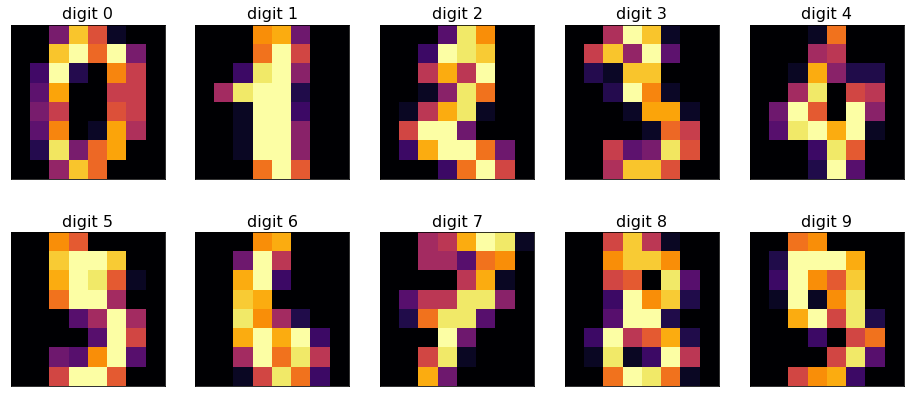

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image, label = X[i_ax].reshape(8, 8), y[i_ax]
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'digit {label}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [7]:
def objective(X, centroids, labels):
        """Calculate objective function"""
        obj = 0
        for i in range(centroids.shape[0]):
            obj += ((X[labels == i] - centroids[i]) ** 2).sum()
        return obj

In [8]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.

        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also
                the number of centroids to generate.
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)

    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j)
        is the distance from i-th object to j-th centroid."""
        distances = np.empty((X.shape[0], cluster_centers.shape[0]))
        for i_obj, obj in enumerate(X):
            for i_clust, clust in enumerate(cluster_centers):
                distances[i_obj, i_clust] = ((clust - obj) ** 2).sum()
        assert distances.shape == (X.shape[0], cluster_centers.shape[0])
        return distances

    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) -
        new clusters that are found by averaging objects belonging
        to the corresponding cluster."""
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            centroids[i] = X[nearest_clusters == i].mean(axis=0)
        return centroids

    def fit(self, X):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters

        best_centroids = None
        best_obj = None
        best_labels = None
        for i_init in range(self.n_init):
            curr_labels = self.random_state.choice(
                np.arange(0, self.n_clusters), (X.shape[0],))
            curr_centroids = self.update_centroids(X, curr_labels)
            for i_iter in range(self.max_iter):
                curr_distances = self.calculate_distances_to_centroids(X, curr_centroids)
                curr_labels = curr_distances.argmin(axis=1)
                curr_centroids = self.update_centroids(X, curr_labels)
            curr_obj = objective(X, curr_centroids, curr_labels)
            if best_centroids is None or curr_obj < best_obj:
                best_centroids = curr_centroids
                best_obj = curr_obj
                best_labels = curr_labels

        assert best_centroids is not None
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.objective_ = best_obj
        return self


    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            return self.calculate_distances_to_centroids(X, self.cluster_centers_).argmin(axis=1)
        else:
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

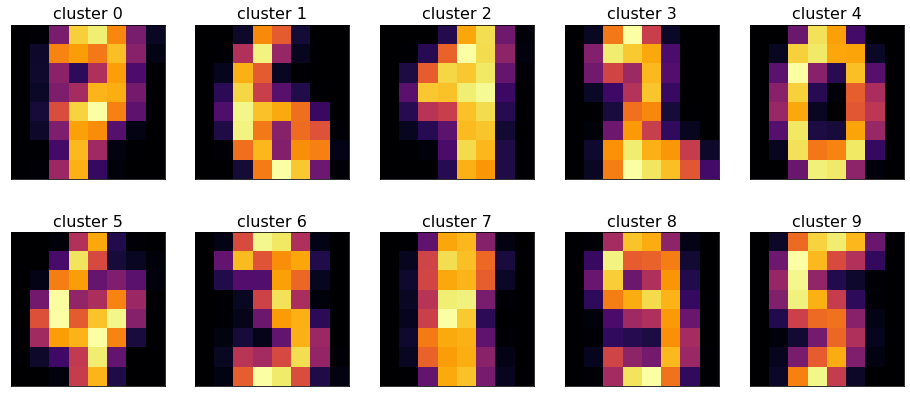

In [9]:
cust_kmeans = CustomKMeans(n_init=10, max_iter=30, n_clusters=10, random_state=42).fit(X)
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = cust_kmeans.cluster_centers_[i_ax].reshape(8, 8)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'cluster {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

**Let's compare with library KMeans**

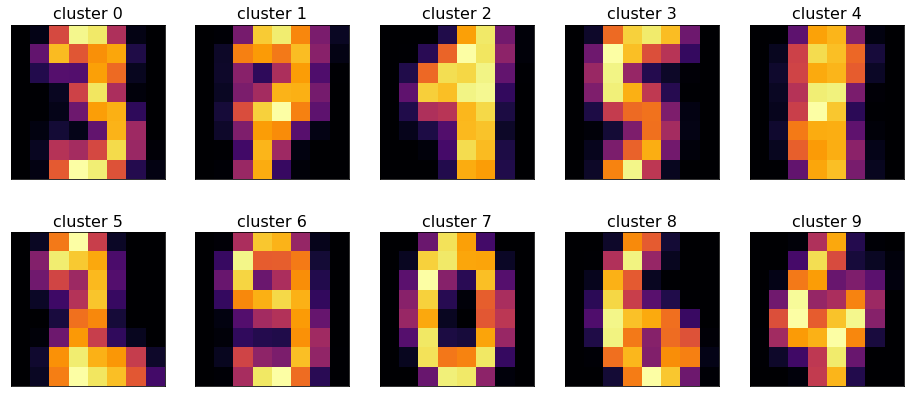

In [10]:
lib_kmeans = KMeans(n_clusters=10, init='random', n_init=10, max_iter=30, random_state=42)
lib_kmeans.fit(X)
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = lib_kmeans.cluster_centers_[i_ax].reshape(8, 8)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'cluster {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

In [11]:
custom_kmeans_labels = cust_kmeans.labels_
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [12]:
init_iter = np.zeros((19, 20))
for i, i_init in enumerate(range(1, 20)):
    for j, i_iter in enumerate(range(1, 200, 10)):
        kmeans = KMeans(
            n_clusters=10, n_init=i_init, max_iter=i_iter,
            init='random', random_state=42)
        kmeans.fit(X)
        init_iter[i, j] = objective(
            X, kmeans.cluster_centers_, kmeans.labels_)

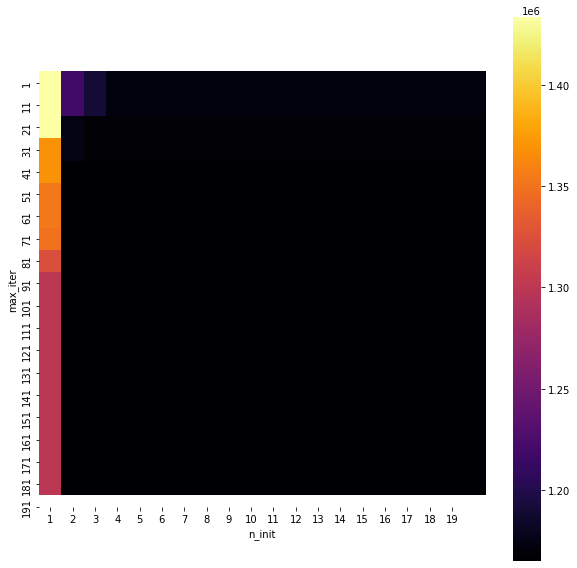

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(init_iter, square=True, cmap='inferno', xticklabels=np.arange(1, 20), yticklabels=np.arange(1, 200, 10))
plt.xlabel('n_init')
plt.ylabel('max_iter')
plt.show()

As we can see the best result is achieved when n_init is greater than 2 and max_iter is greater than 50

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [14]:
from sklearn.cluster import AgglomerativeClustering

In [15]:
agglom_clust = AgglomerativeClustering(n_clusters=10, compute_distances=True)
agglom_clust.fit_predict(X)
kmeans = KMeans(n_clusters=10, init='random', n_init=5, max_iter=50, random_state=42)
kmeans.fit(X);

In [16]:
hierarchical_labels = agglom_clust.labels_
kmeans_labels = kmeans.labels_

In [17]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

#### KMeans cluster centers

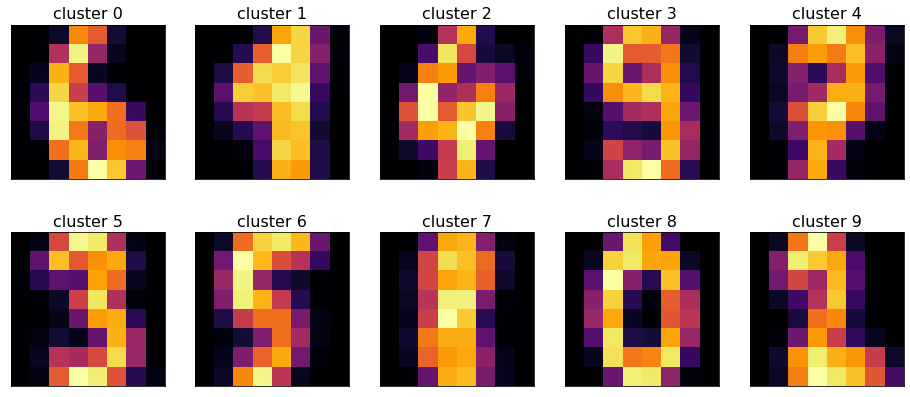

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = kmeans.cluster_centers_[i_ax].reshape(8, 8)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'cluster {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

#### Agglomerative clusters centers

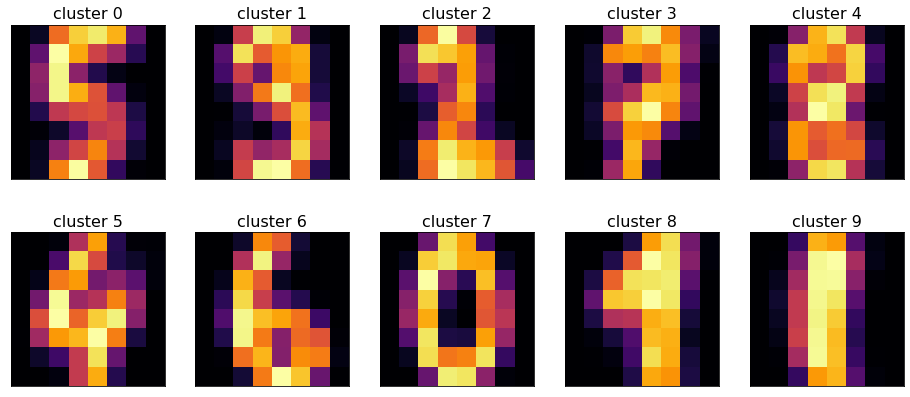

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = X[agglom_clust.labels_ == i_ax].mean(axis=0).reshape(8, 8)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'cluster {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [20]:
from sklearn.metrics import silhouette_score

In [21]:
df = pd.DataFrame(columns=['AgglomerativeClustering', 'KMeans'])
for cl_count in range(2, 21):
    a_clust = AgglomerativeClustering(n_clusters=cl_count).fit(X)
    kmeans = KMeans(n_clusters=cl_count, init='random', random_state=42).fit(X)
    df.loc[cl_count] = silhouette_score(X, a_clust.labels_), silhouette_score(X, kmeans.labels_)
df

,AgglomerativeClustering,KMeans
2,0.116740,0.118328
3,0.111890,0.126496
4,0.108960,0.128220
5,0.118881,0.137889
6,0.137011,0.151592
7,0.153686,0.163482
8,0.170563,0.178697
9,0.180620,0.189321
10,0.178497,0.182558
11,0.176373,0.183233


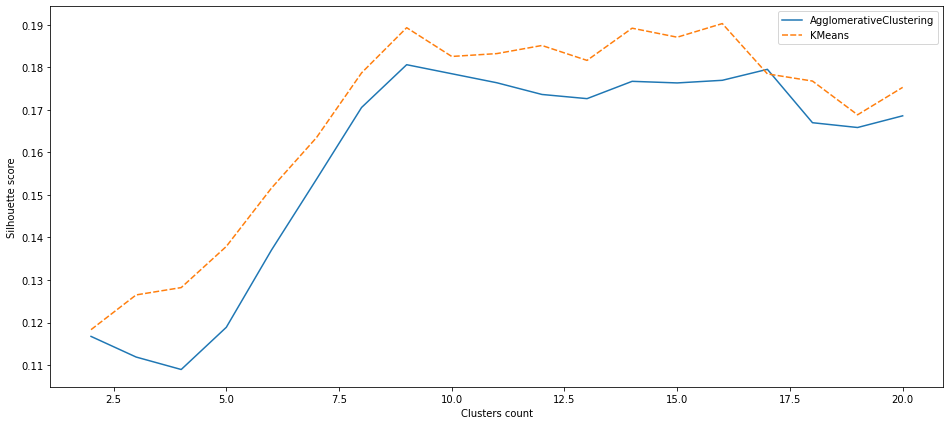

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.lineplot(data=df, ax=ax)
ax.set_xlabel('Clusters count')
ax.set_ylabel('Silhouette score')
plt.show()

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [23]:
from sklearn.metrics import v_measure_score

In [24]:
df = pd.DataFrame(columns=['AgglomerativeClustering', 'KMeans'])
for cl_count in range(2, 21):
    a_clust = AgglomerativeClustering(n_clusters=cl_count).fit(X)
    kmeans = KMeans(n_clusters=cl_count, init='random', random_state=42).fit(X)
    df.loc[cl_count] = v_measure_score(y, a_clust.labels_), v_measure_score(y, kmeans.labels_)
df

,AgglomerativeClustering,KMeans
2,0.408242,0.360012
3,0.544061,0.404123
4,0.621164,0.459583
5,0.709654,0.579417
6,0.756666,0.595229
7,0.798301,0.657031
8,0.845777,0.711814
9,0.844660,0.722852
10,0.868170,0.747701
11,0.855380,0.769257


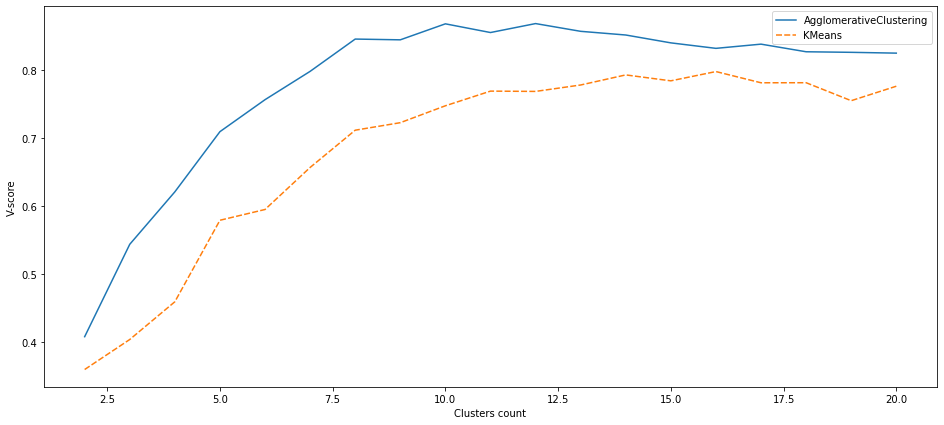

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.lineplot(data=df, ax=ax)
ax.set_xlabel('Clusters count')
ax.set_ylabel('V-score')
plt.show()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [26]:
from sklearn.decomposition import TruncatedSVD

In [27]:
df = pd.DataFrame(columns=[
    'AgglomerativeClustering(V-score)', 'KMeans(V-score)',
    'AgglomerativeClustering(Silhouette)', 'KMeans(Silhouette)'
])
for decomp in [2, 5, 10, 20, 64]:
    if decomp != 64:
        X_red = TruncatedSVD(n_components=decomp, random_state=42).fit_transform(X)
    else:
        X_red = X
    a_clust = AgglomerativeClustering(n_clusters=10).fit(X_red)
    kmeans = KMeans(n_clusters=10, init='random', random_state=42).fit(X_red)
    df.loc[decomp] = v_measure_score(y, a_clust.labels_), v_measure_score(y, kmeans.labels_), \
                     silhouette_score(X_red, a_clust.labels_), silhouette_score(X_red, kmeans.labels_)
df

,AgglomerativeClustering(V-score),KMeans(V-score),AgglomerativeClustering(Silhouette),KMeans(Silhouette)
2,0.333719,0.335862,0.280817,0.347402
5,0.675604,0.634800,0.272741,0.312341
10,0.825975,0.723607,0.250712,0.263484
20,0.814388,0.737570,0.197134,0.212429
64,0.868170,0.747701,0.178497,0.182558


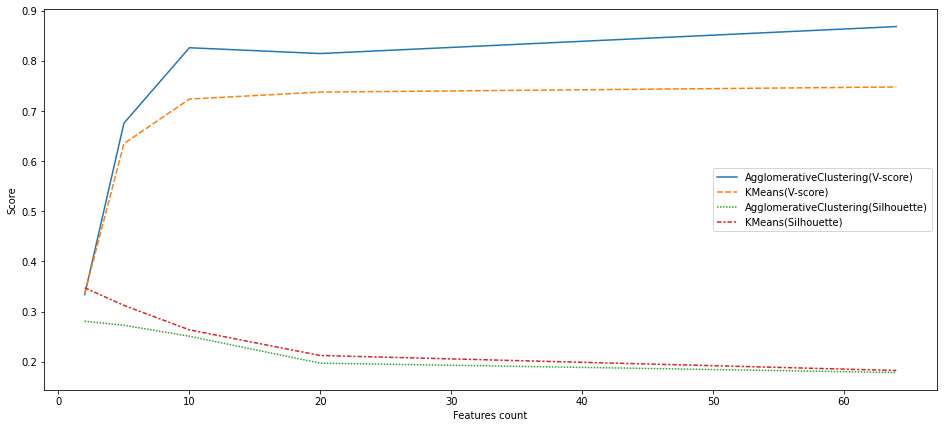

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.lineplot(data=df, ax=ax)
ax.set_xlabel('Features count')
ax.set_ylabel('Score')
plt.show()

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [29]:
from sklearn.manifold import TSNE

In [30]:
X_red = TSNE(n_components=2, random_state=42).fit_transform(X)

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


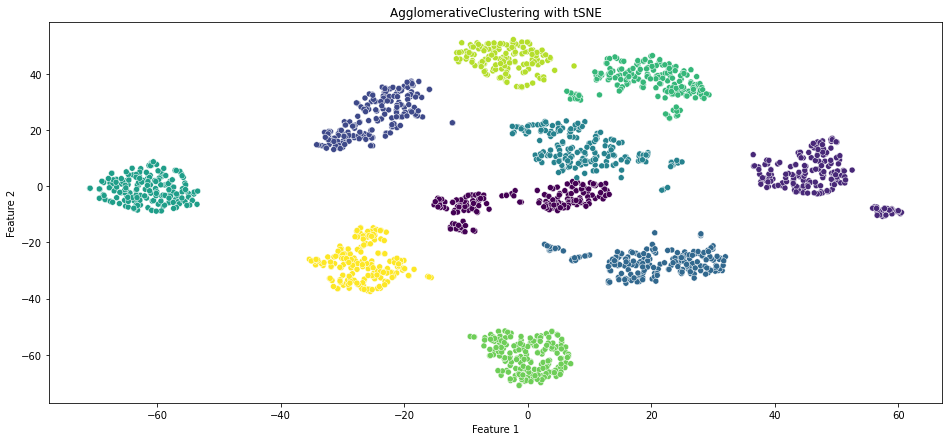

In [31]:
a_clust = AgglomerativeClustering(n_clusters=10).fit(X_red)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X_red[:, 0], y=X_red[:, 1], ax=ax, c=a_clust.labels_)
ax.set_title('AgglomerativeClustering with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

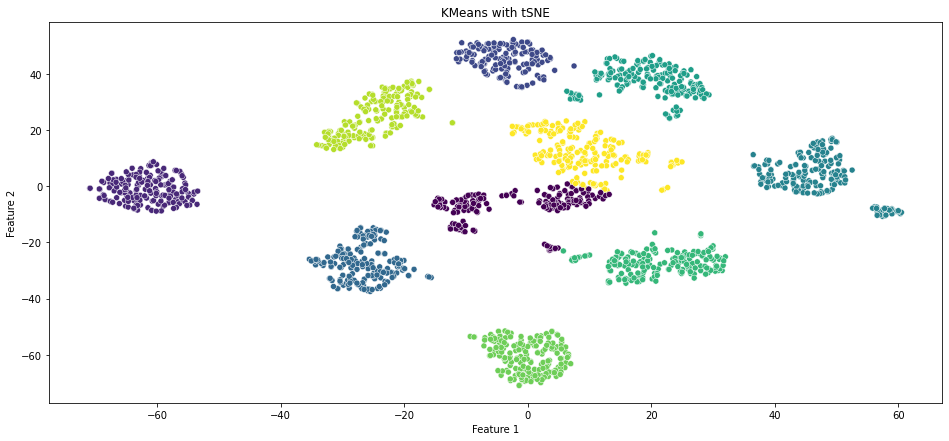

In [32]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_red)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X_red[:, 0], y=X_red[:, 1], ax=ax, c=kmeans.labels_)
ax.set_title('KMeans with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [33]:
df = pd.DataFrame(columns=['score'])
clustering = AgglomerativeClustering(n_clusters=10).fit(X)
df.loc['Agglomerative, silhouette'] = silhouette_score(X, clustering.labels_)
df.loc['Agglomerative, V-measure'] = v_measure_score(y, clustering.labels_)
clustering = AgglomerativeClustering(n_clusters=10).fit(X_red)
df.loc['Agglomerative(tSNE), silhouette'] = silhouette_score(X_red, clustering.labels_)
df.loc['Agglomerative(tSNE), V-measure'] = v_measure_score(y, clustering.labels_)
clustering = KMeans(n_clusters=10, random_state=42).fit(X)
df.loc['KMeans, silhouette'] = silhouette_score(X, clustering.labels_)
df.loc['KMeans, V-measure'] = v_measure_score(y, clustering.labels_)
clustering = AgglomerativeClustering(n_clusters=10).fit(X_red)
df.loc['KMeans(tSNE), silhouette'] = silhouette_score(X_red, clustering.labels_)
df.loc['KMeans(tSNE), V-measure'] = v_measure_score(y, clustering.labels_)
df

,score
"Agglomerative, silhouette",0.178497
"Agglomerative, V-measure",0.868170
"Agglomerative(tSNE), silhouette",0.647254
"Agglomerative(tSNE), V-measure",0.920765
"KMeans, silhouette",0.182443
"KMeans, V-measure",0.741468
"KMeans(tSNE), silhouette",0.647254
"KMeans(tSNE), V-measure",0.920765


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


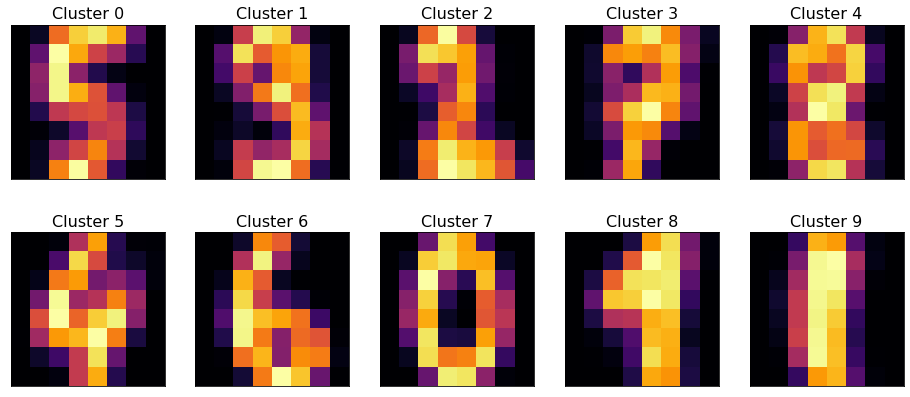

In [34]:
X_red = TSNE(n_components=2, random_state=42).fit_transform(X)
clust = KMeans(n_clusters=10, random_state=42).fit(X_red)
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = X[agglom_clust.labels_ == i_ax].mean(axis=0).reshape(8, 8)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'Cluster {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

It was decided to choose KMeans and tSNE, as they give optimal results (the best V-measure and silhouette)

Although most of the digits are well defined and readable, there are some clusters that are difficult to correlate a particular digit (e.g. clusters 1, 3, 9).

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Within this dataset, I found K-means to be the best, because when drawing the centers of clusters, the numbers are better distinguishable than when using hierarchical clustering.

As for the settings, of course it depends. A trivial example is that with too small values of `n_init` and `max_iter` the accuracy will be too low. However, when you reach a certain value, further increase will not bring more accuracy.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Hierarchical clustering is not designed to classify new data, but there is can used the KNN method to create clusters on new data based on the previous data (clusters). It may also be possible to compare V-score and silhouette (Metrics on old data + old model, new data + old model and new data + new model).

To assess the quality of clustering, there is can be created a new model on the new data and compare the fitted clusters with clusters based on the old model

**(0.5 points)** Does dimensionality reduction improve clustering results?

In general, yes, it should improve or at least not worsen the model. However, from my own observations, I can say that with the data provided, it rather makes it worse. Even though the metrics increase, some clusters are worse differentiated from each other than with all traits. So, reducing the traits from 64 to 2 is a bad way to go, it seems to me. Using singular value decomposition seems to me a better output, using 20 features.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

* First, if clusters start to overlap when decreasing the dimensionality, this is a bad method. In general, you can measure the distances between clusters to assess quality (Meaning between the outermost elements of the clusters).
* You can also measure the density of the cluster elements. That is, if after downsizing the data turns out to be evenly smeared across features, then this is clearly a bad downsizing method.

You will most likely need to compare with the original data.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [36]:
from sklearn.datasets import fetch_openml

In [37]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy()
X.shape

(70000, 784)

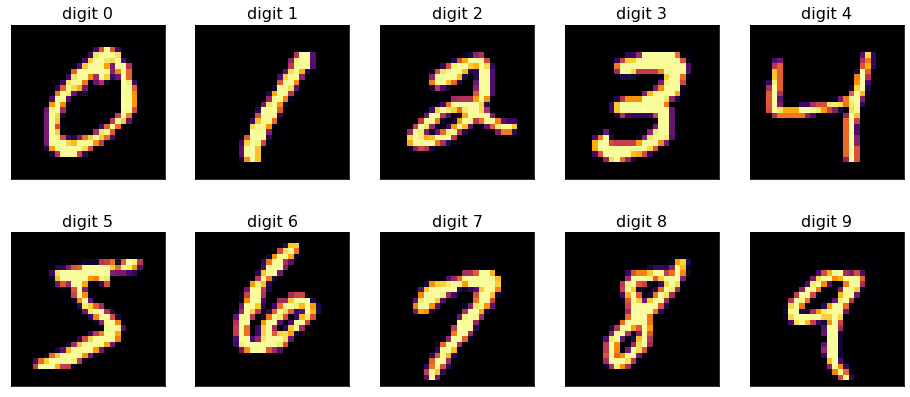

In [38]:
fig, ax = plt.subplots(2, 5, figsize=(16, 7))
for i_ax, axis in enumerate(ax.flatten()):
    image = X[y == str(i_ax)][0].reshape(28, 28)
    axis: plt.Axes
    axis.imshow(image, cmap='inferno')
    axis.set_title(f'digit {i_ax}', fontsize=16)
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

In [39]:
df = pd.DataFrame(columns=['silhouette', 'V-score'])

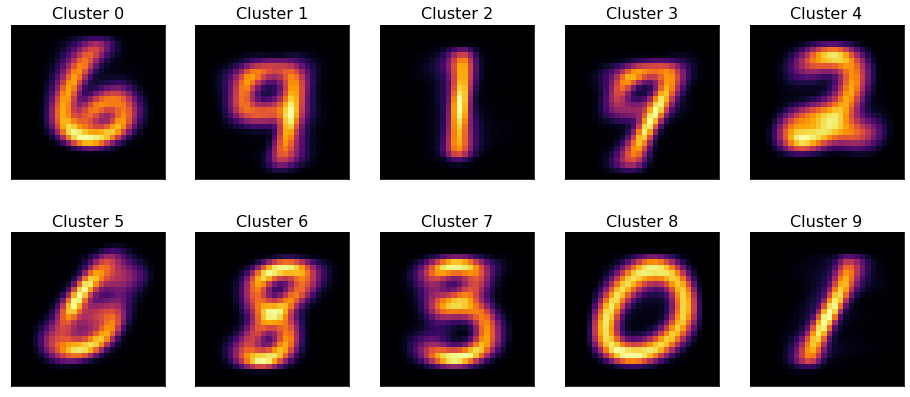

In [40]:
clust = KMeans(n_clusters=10, n_init=10, max_iter=50, random_state=42).fit(X)
plot_cluster_centers(None, clust, shape=(28, 28), centers=True)

In [41]:
df.loc['<KMeans(n_init=10, max_iter=50, init=\'k-means++\'), data=original>'] = \
    silhouette_score(X, clust.labels_), v_measure_score(y, clust.labels_)

Since 784 attributes are too many and the calculations are very long, it is necessary to reduce the dimensionality. You can also tell from the results that they are not very good (regarding silhouette - the best value is 1 and values near 0 indicate overlapping clusters)

In [42]:
df_0 = pd.DataFrame(columns=['KMeans(V-score)', 'KMeans(Silhouette)'])
for decomp in [2, 5, 10, 25, 50, 64, 128, 256]:
    X_red = TruncatedSVD(n_components=decomp, random_state=42).fit_transform(X)
    clust = KMeans(n_clusters=10, n_init=10, max_iter=50, random_state=42).fit(X_red)
    df_0.loc[decomp] = v_measure_score(y, clust.labels_), silhouette_score(X_red, clust.labels_)
df_0

,KMeans(V-score),KMeans(Silhouette)
2,0.198794,0.327876
5,0.418608,0.211375
10,0.466076,0.169469
25,0.486716,0.111789
50,0.499260,0.085715
64,0.497295,0.079422
128,0.484849,0.064626
256,0.486746,0.058930


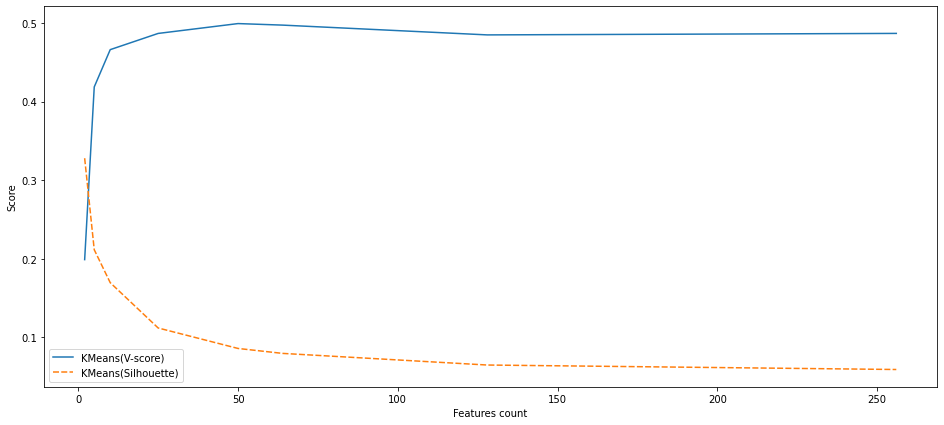

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.lineplot(data=df_0, ax=ax)
ax.set_xlabel('Features count')
ax.set_ylabel('Score')
plt.show()

Let's choose `n_components=64` for `TruncatedSVD`

In [44]:
comps_tSVD = 64
X_tSVD = TruncatedSVD(n_components=comps_tSVD, random_state=42).fit_transform(X)
X_tSVD.shape

(70000, 64)

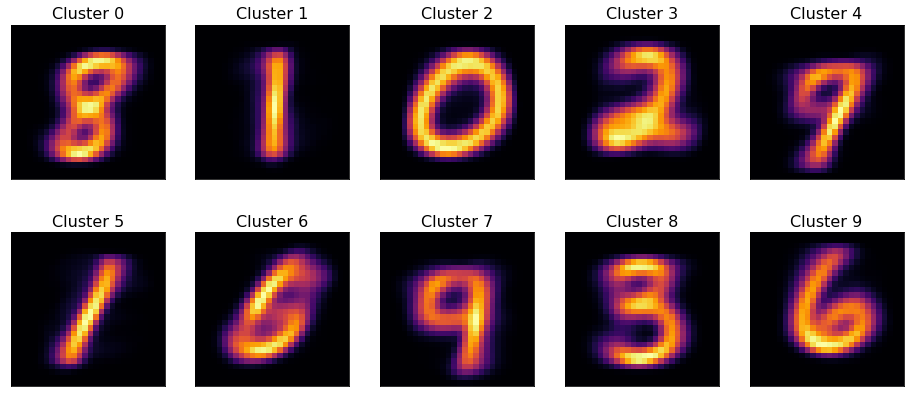

In [45]:
clust = KMeans(n_clusters=10, n_init=10, max_iter=50, random_state=42).fit(X_tSVD)
plot_cluster_centers(X, clust, shape=(28, 28))

In [46]:
df.loc[f'<KMeans(n_init=10, max_iter=50, init=\'k-means++\'), data=tSVD(n_components={comps_tSVD})>'] = \
    silhouette_score(X_tSVD, clust.labels_), v_measure_score(y, clust.labels_)

In [47]:
X_tSNE = TSNE(n_components=2, random_state=42, n_jobs=16).fit_transform(X)
X_tSNE.shape

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(70000, 2)

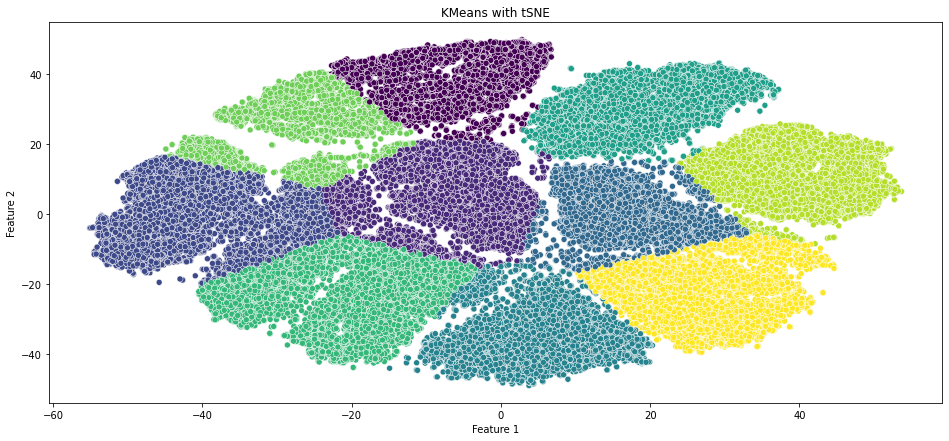

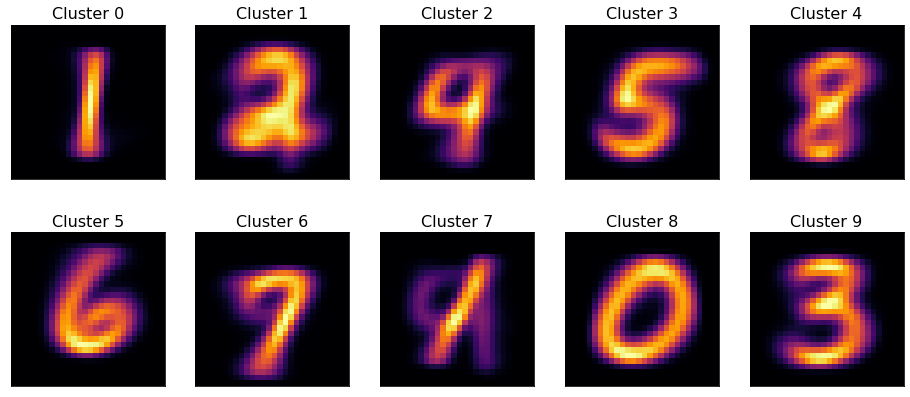

In [48]:
clust = KMeans(n_clusters=10, random_state=42).fit(X_tSNE)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X_tSNE[:, 0], y=X_tSNE[:, 1], ax=ax, c=clust.labels_)
ax.set_title('KMeans with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()
plot_cluster_centers(X, clust, shape=(28, 28))

In [49]:
df.loc[f'<KMeans(init=\'k-means++\'), data=tSNE(n_components=2)>'] = \
    silhouette_score(X_tSNE, clust.labels_), v_measure_score(y, clust.labels_)

As we see above, clustering goes very poorly. We can see the clusters on the graph, but the model does not separate the data correctly (although mathematically correct).  Hierarchical clustering is not used because it takes a long time to fit.

In [50]:
new_size = 10000
X2 = X[:new_size]
y2 = y[:new_size]
X2_tSVD = TruncatedSVD(n_components=comps_tSVD, random_state=42).fit_transform(X2)
X2_tSNE = TSNE(n_components=2, random_state=42, n_jobs=16).fit_transform(X2)
np.vstack(np.unique(y2, return_counts=True))

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
       [1001, 1127, 991, 1032, 980, 863, 1014, 1070, 944, 978]],
      dtype=object)

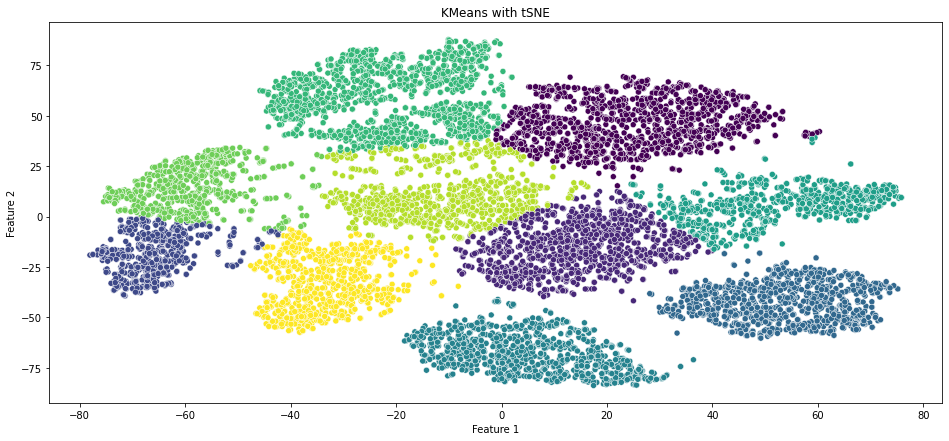

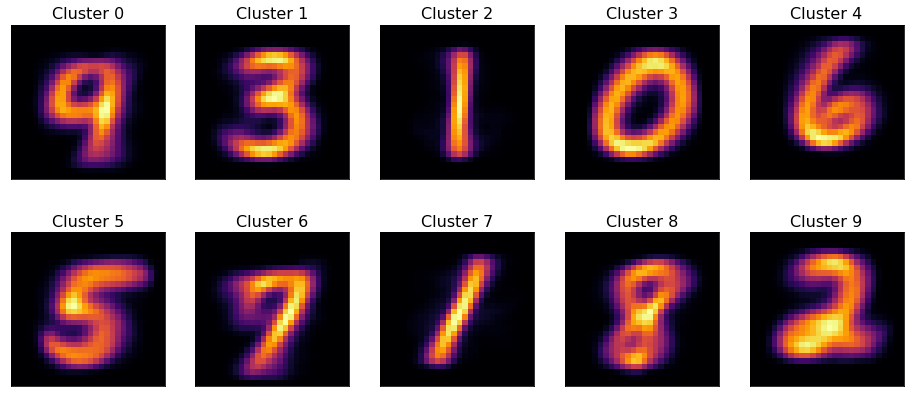

In [51]:
clust = KMeans(n_clusters=10, random_state=42).fit(X2_tSNE)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X2_tSNE[:, 0], y=X2_tSNE[:, 1], ax=ax, c=clust.labels_)
ax.set_title('KMeans with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()
plot_cluster_centers(X2, clust, shape=(28, 28))

In [52]:
df.loc[f'<KMeans(init=\'k-means++\'), data=tSNE(n_components=2, size={new_size})>'] = \
    silhouette_score(X2_tSNE, clust.labels_), v_measure_score(y2, clust.labels_)

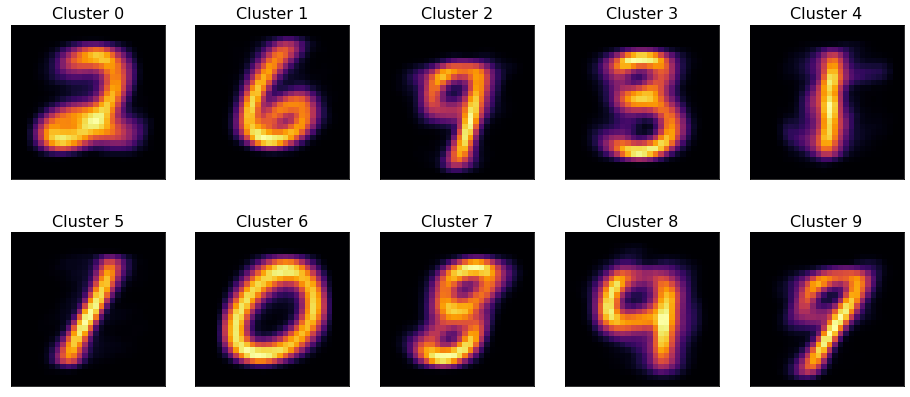

In [53]:
clust = KMeans(n_clusters=10, random_state=42).fit(X2_tSVD)
plot_cluster_centers(X2, clust, shape=(28, 28))

In [54]:
df.loc[f'<KMeans(init=\'k-means++\'), data=tSVD(n_components={comps_tSVD}, size={new_size})>'] = \
    silhouette_score(X2_tSVD, clust.labels_), v_measure_score(y2, clust.labels_)

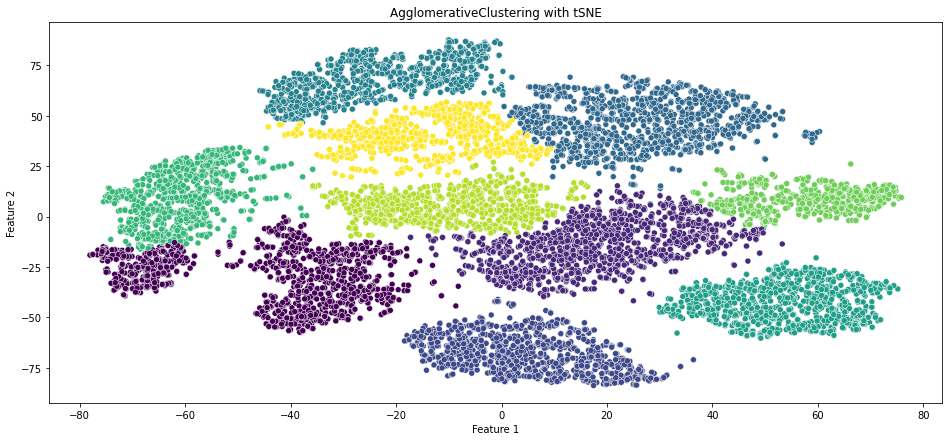

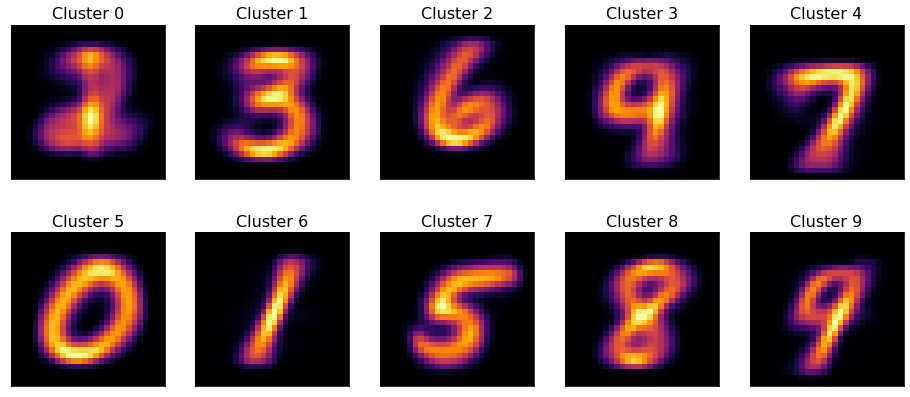

In [55]:
clust = AgglomerativeClustering(n_clusters=10).fit(X2_tSNE)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X2_tSNE[:, 0], y=X2_tSNE[:, 1], ax=ax, c=clust.labels_)
ax.set_title('AgglomerativeClustering with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()
plot_cluster_centers(X2, clust, shape=(28, 28))

In [56]:
df.loc[f'<AgglomerativeClustering(), data=tSNE(n_components=2, size={new_size})>'] = \
    silhouette_score(X2_tSNE, clust.labels_), v_measure_score(y2, clust.labels_)

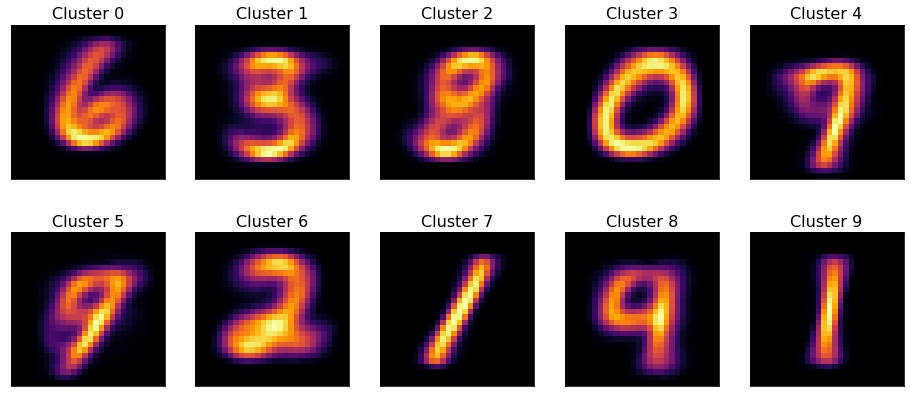

In [57]:
clust = AgglomerativeClustering(n_clusters=10).fit(X2_tSVD)
plot_cluster_centers(X2, clust, shape=(28, 28))

In [58]:
df.loc[f'<AgglomerativeClustering(), data=tSVD(n_components={comps_tSVD}, size={new_size})>'] = \
    silhouette_score(X2_tSNE, clust.labels_), v_measure_score(y2, clust.labels_)

In [59]:
new_size2 = 2000
X3 = X[:new_size]
y3 = y[:new_size]
X3_tSNE = TSNE(n_components=2, random_state=42, n_jobs=16).fit_transform(X3)
np.vstack(np.unique(y3, return_counts=True))

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
       [1001, 1127, 991, 1032, 980, 863, 1014, 1070, 944, 978]],
      dtype=object)

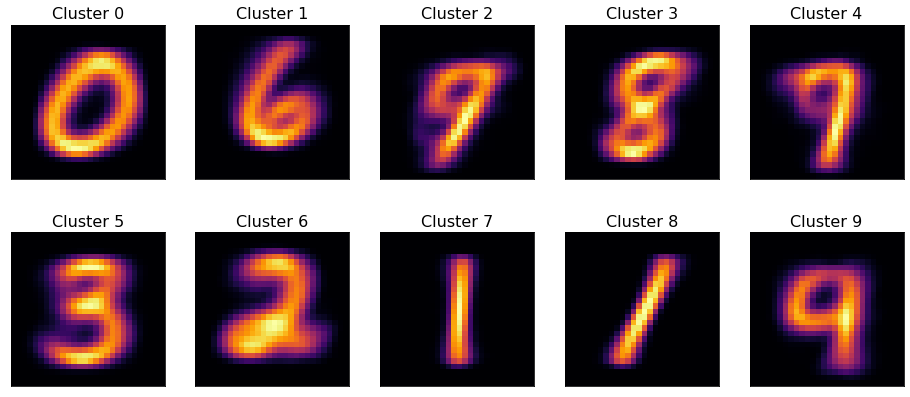

In [60]:
clust = AgglomerativeClustering(n_clusters=10).fit(X3)
plot_cluster_centers(X3, clust, shape=(28, 28))

In [61]:
df.loc[f'<AgglomerativeClustering(), data=original(size={new_size2})>'] = \
    silhouette_score(X3, clust.labels_), v_measure_score(y3, clust.labels_)

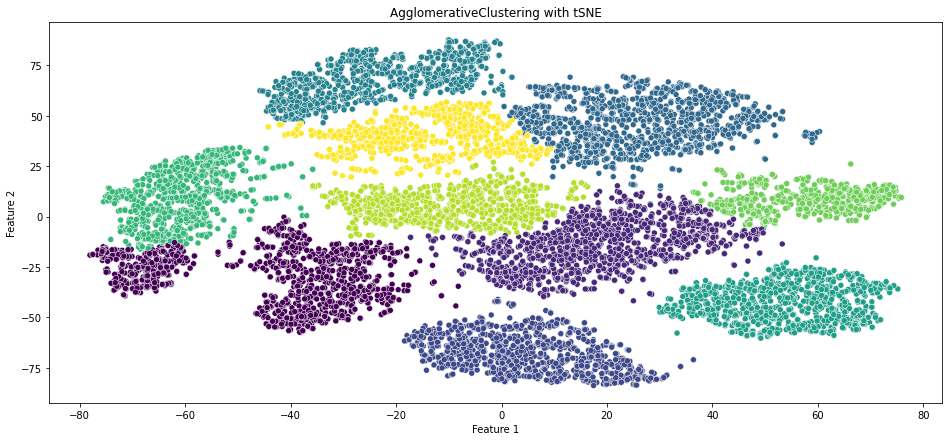

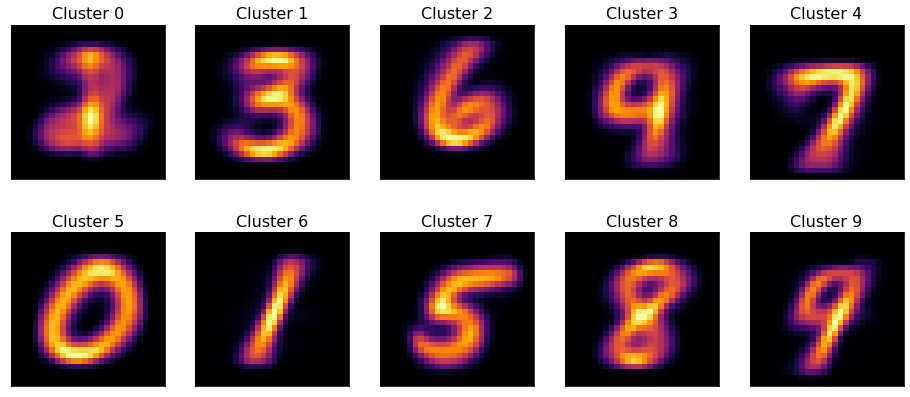

In [62]:
clust = AgglomerativeClustering(n_clusters=10).fit(X3_tSNE)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X3_tSNE[:, 0], y=X3_tSNE[:, 1], ax=ax, c=clust.labels_)
ax.set_title('AgglomerativeClustering with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()
plot_cluster_centers(X3, clust, shape=(28, 28))

In [63]:
df.loc[f'<AgglomerativeClustering(), data=tSNE(n_components=2, size={new_size2})>'] = \
    silhouette_score(X3_tSNE, clust.labels_), v_measure_score(y3, clust.labels_)

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' i

,AgglomerativeClustering(V-score),AgglomerativeClustering(Silhouette)
2,0.735822,0.443681
3,0.735822,0.443681
4,0.735822,0.443681


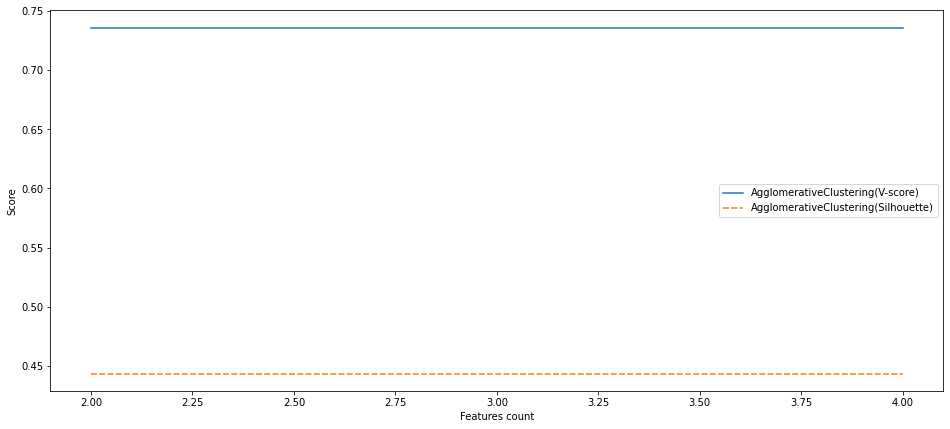

In [64]:
df_0 = pd.DataFrame(columns=['AgglomerativeClustering(V-score)', 'AgglomerativeClustering(Silhouette)'])
for comps in range(2, 5):
    X_red = TSNE(n_components=2, random_state=42, n_jobs=16).fit_transform(X3)
    clust = AgglomerativeClustering(n_clusters=10).fit(X_red)
    df_0.loc[comps] = v_measure_score(y3, clust.labels_), silhouette_score(X_red, clust.labels_)
display(df_0)

fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.lineplot(data=df_0, ax=ax)
ax.set_xlabel('Features count')
ax.set_ylabel('Score')
plt.show()

As we see, the number of components does not change the metric.

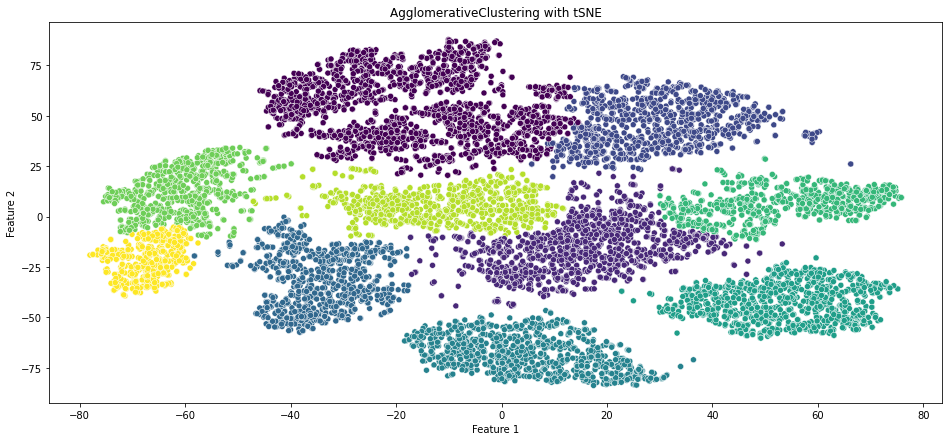

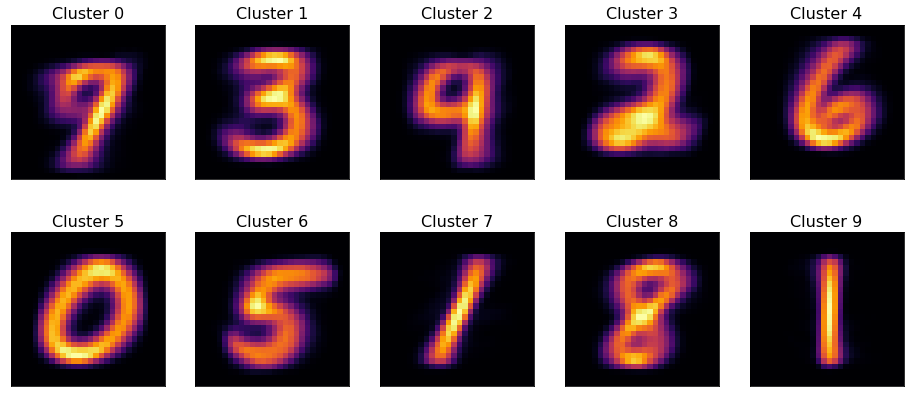

In [65]:
# 'complete', 'average', 'single'
clust = AgglomerativeClustering(n_clusters=10, linkage='average').fit(X3_tSNE)
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax: plt.Axes
sns.scatterplot(x=X3_tSNE[:, 0], y=X3_tSNE[:, 1], ax=ax, c=clust.labels_)
ax.set_title('AgglomerativeClustering with tSNE')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()
plot_cluster_centers(X3, clust, shape=(28, 28))

`'Average'` gives the best results (of `'complete', 'average', 'single'`), but the clusters still look worse than when `linkage='ward'`

In [66]:
df.loc[f'<AgglomerativeClustering(linkage=\'average\'), data=tSNE(n_components=2, size={new_size2})>'] = \
    silhouette_score(X3_tSNE, clust.labels_), v_measure_score(y3, clust.labels_)

In [67]:
df

,silhouette,V-score
"<KMeans(n_init=10, max_iter=50, init='k-means++'), data=original>",0.058684,0.499784
"<KMeans(n_init=10, max_iter=50, init='k-means++'), data=tSVD(n_components=64)>",0.079422,0.497295
"<KMeans(init='k-means++'), data=tSNE(n_components=2)>",0.388674,0.751080
"<KMeans(init='k-means++'), data=tSNE(n_components=2, size=10000)>",0.473255,0.730090
"<KMeans(init='k-means++'), data=tSVD(n_components=64, size=10000)>",0.081483,0.475652
"<AgglomerativeClustering(), data=tSNE(n_components=2, size=10000)>",0.443681,0.735822
"<AgglomerativeClustering(), data=tSVD(n_components=64, size=10000)>",0.223982,0.630789
"<AgglomerativeClustering(), data=original(size=2000)>",0.032955,0.662548
"<AgglomerativeClustering(), data=tSNE(n_components=2, size=2000)>",0.443681,0.735822
"<AgglomerativeClustering(linkage='average'), data=tSNE(n_components=2, size=2000)>",0.452031,0.748817


It seems to me that the best result will be obtained by using `AgglomerativeClustering` with parameter `linkage='ward'` and preprocessing the data with `tSNE`, but the full processing of all data cannot be done, because it requires a lot of computing power.